In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.870       # 1/h
K_S    = 0.215       # g/l
Y_XS   = 0.496       # g/g
Y_PX   = 0.2         # g/g
S_F    = 1.43 * 200  # g/l

# Initial conditions
X_0 = 5.85
S_0 = 0.013
P_0 = 0
V_0 = 1.56

# ODE solver parameters
ODE_SOLVER = 'LSODA'

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 

# System dynamics
def system_dynamics(t, y, F) -> np.array:
    
    # def q(t):
        # k = 0.6
        # K_d = 0.025
        # n = 1
        # return k / (1 + (P / K_d)**n)
        
    def q(t):
        return (2 - 0.1 *  (MU_MAX * S / (K_S + S))) * 0.005 * X 
       
    X, S, P, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dP_dt = q(t) * X - (F / V) * P
    dV_dt = F
    return np.array([dX_dt, dS_dt, dP_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

def plot_solution(sol: solve_ivp) -> None:
    plt.figure(figsize=(12,4))
    plt.subplot(2,1,1)
    plt.plot(sol.t, sol.y[0], label='Biomass')
    plt.plot(sol.t, sol.y[1], label='Substrate')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/l)')
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(sol.t, sol.y[2], label='Product')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/l)')
    plt.legend()
    plt.show()

In [1]:
## Example simulation
# t_eval = np.linspace(T_START, T_END, NUM_SAMPLES)
# y0 = [X_0, S_0, P_0, V_0]
# solution = solve_ode(system_dynamics, [T_START, T_END], y0, ODE_SOLVER, t_eval, (0.01,))
# plot_solution(solution)

In [ ]:
# MPC parameters
dt = 0.1                         # Time step
L = int(TIME_RANGE / dt)       # Number of steps
N_p = 10                         # Prediction horizon
Q = 10                      # Weight for tracking
Q_term = 0.0                     # Weight for terminal state
R = 1                            # Weight for control effort
OPTIMIZATION_METHOD = 'SLSQP' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# X_setpoint
P_sp = 10

print(f'Number of steps: {L} and dt: {dt}')

In [ ]:
# ----- Cost function -----
def cost_function(F_opt: list, X: float, S: float, P: float, V: float) -> float:
    J = 0
    for k in range(N_p):
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X, S, P, V], method=ODE_SOLVER, t_eval=[dt], args=(F_opt[k],))      
        X_next = sol.y[0][-1]
        S_next = sol.y[1][-1]
        P_next = sol.y[2][-1]
        V_next = sol.y[3][-1]
        J += Q * (P_sp - P_next) ** 2
        
        # Penalize substrate concentration
        if S_next > 1:
            J += 1000 * (S_next - 1) ** 2
        
        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2
        X, S, P, V = X_next, S_next, P_next, V_next
        
    return J

In [ ]:
X = np.zeros(L)
S = np.zeros(L)
P = np.zeros(L)
V = np.zeros(L)
F = np.zeros(L)
X[0], S[0], P[0], V[0] = X_0, S_0, P_0, V_0

for i in tqdm(range(L-1)):
    res = minimize(cost_function, np.zeros(N_p), args=(X[i], S[i], P[i], V[i]), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    F_new = res.x[0]
    # Enforce constraints on ΔF 
    F[i+1] = np.clip(F[i] + np.clip(F_new - F[i], -DELTA_F_MAX, DELTA_F_MAX), F_MIN, F_MAX)
    sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X[i], S[i], P[i], V[i]], method=ODE_SOLVER, t_eval=[dt], args=(F_new,))
    X[i+1] = sol.y[0][-1]
    S[i+1] = sol.y[1][-1]
    P[i+1] = sol.y[2][-1]
    V[i+1] = sol.y[3][-1]


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


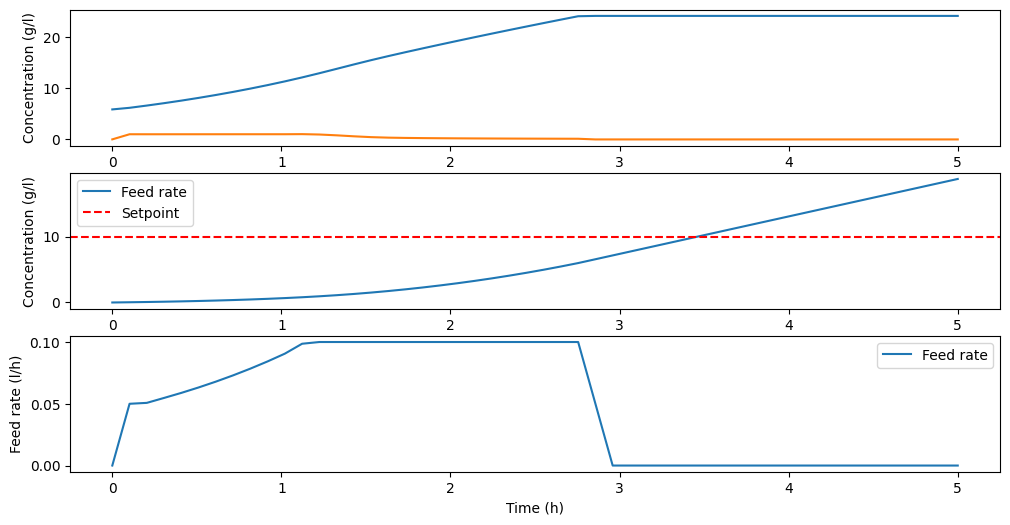

In [ ]:
time= np.linspace(T_START, T_END, L)
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(time, X, label='Biomass')
plt.plot(time, S, label='Substrate')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')

plt.subplot(3,1,2)
plt.plot(time, P, label='Feed rate')
plt.axhline(y=P_sp, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(time, F, label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()
plt.show()

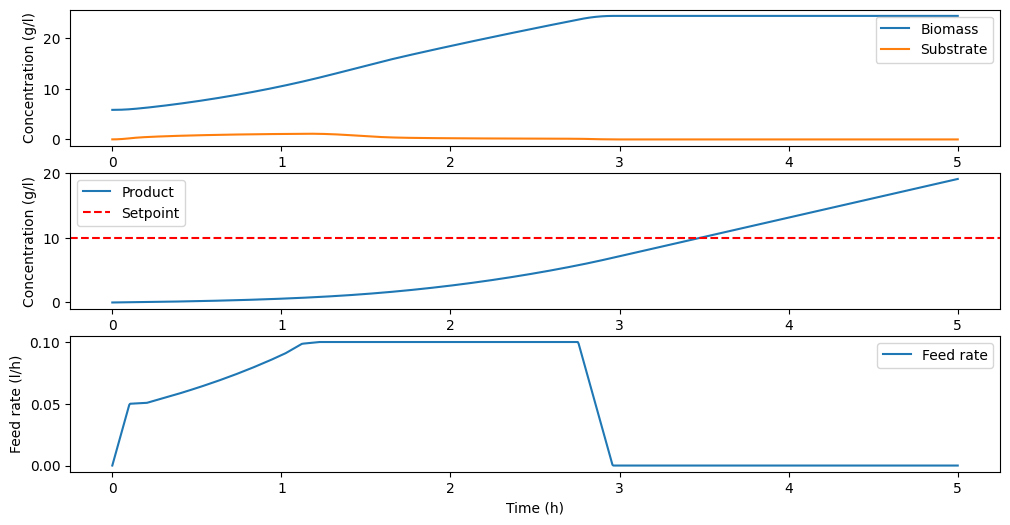

In [ ]:
from scipy.interpolate import interp1d

# System dynamics
def simulate(t, y, F_func) -> np.array:
    
    # def q(t):
        # k = 0.6
        # K_d = 0.025
        # n = 1
        # return k / (1 + (P / K_d)**n)
        
    def q(t):
        return (2 - 0.1 *  (MU_MAX * S / (K_S + S))) * 0.005 * X 
    
    F = F_func(t)   
    
    X, S, P, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dP_dt = q(t) * X - (F / V) * P
    dV_dt = F
    return np.array([dX_dt, dS_dt, dP_dt, dV_dt])

F_func = interp1d(time, F, kind='linear', fill_value='extrapolate')
t_eval = np.linspace(T_START, T_END, NUM_SAMPLES)
sol = solve_ivp(simulate, t_span=[T_START, T_END], y0=[X_0, S_0, P_0, V_0], method=ODE_SOLVER, t_eval=t_eval, args=(F_func,))

# Plot results
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(sol.t, sol.y[0], label='Biomass')
plt.plot(sol.t, sol.y[1], label='Substrate')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(sol.t, sol.y[2], label='Product')
plt.axhline(y=P_sp, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(sol.t, F_func(sol.t), label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()
plt.show()